In [1]:
import matplotlib.pyplot as plt
from stl import mesh

from align import best_degree_for_rotation_bisearch
from clean import clean
from diff import get_upper_cube, get_closest_face, degrees_to_face_y
from display import plot_cube_around_z, plot_3d, plot_grids, plot_faces
from rotate import rotate_x, rotate_z
from sample import sample_target_surface

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
X, Y, Z = 0, 1, 2

In [3]:
m = mesh.Mesh.from_file('Blue09.STL')

raw_data = m.vectors.reshape(-1, 3)

print(f'Convert mesh vertices to an array of xyz. Shape: {m.vectors.shape} -> {raw_data.shape}')

print(f'max x: {max(raw_data[:, 0])}, min x: {min(raw_data[:, 0])}')
print(f'max y: {max(raw_data[:, 1])}, min y: {min(raw_data[:, 1])}')
print(f'max z: {max(raw_data[:, 2])}, min z: {min(raw_data[:, 2])}')

Convert mesh vertices to an array of xyz. Shape: (694620, 3, 3) -> (2083860, 3)
max x: 58.04283142089844, min x: -38.69776916503906
max y: 53.5966682434082, min y: -59.960235595703125
max z: 63.54637145996094, min z: 32.51903533935547


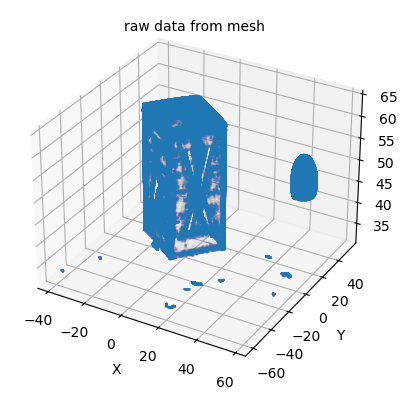

In [4]:
plot_3d(raw_data, title='raw data from mesh')

In [5]:
cube = clean(raw_data)

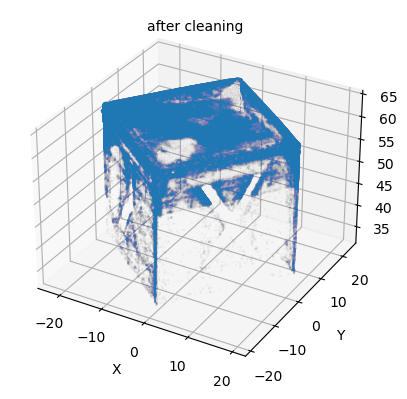

In [6]:
plot_3d(cube, title='after cleaning')

In [7]:
d = best_degree_for_rotation_bisearch(cube)

print(f'rotate {d} degrees to align with axis')

rotate 36.675 degrees to align with axis


In [8]:
aligned_cube = rotate_z(cube, d)

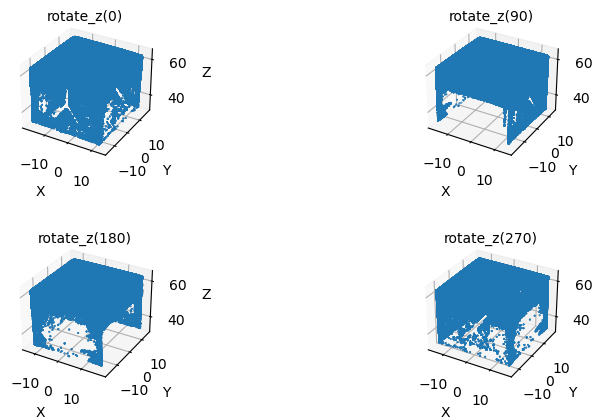

In [9]:
plot_cube_around_z(aligned_cube, s=0.09)

In [10]:
upper = get_upper_cube(aligned_cube)

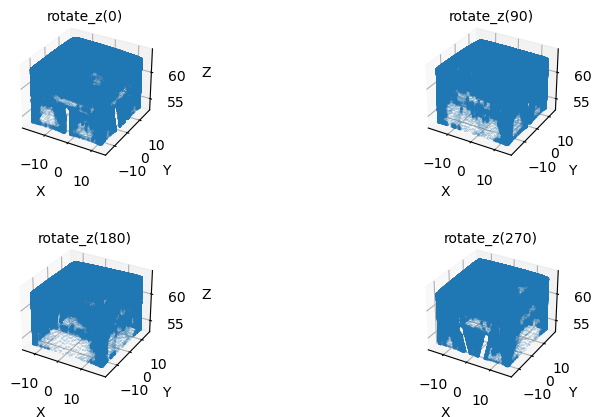

In [11]:
plot_cube_around_z(upper, s=0.001)

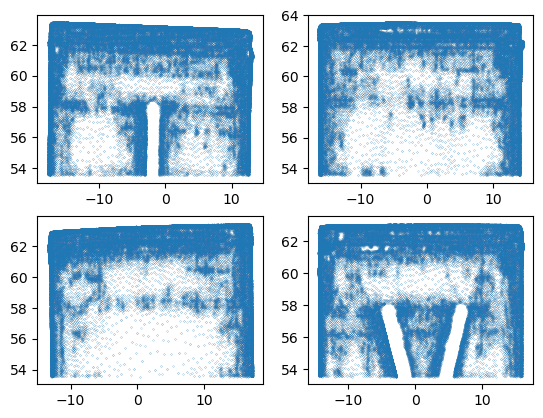

In [12]:
plot_faces(upper)

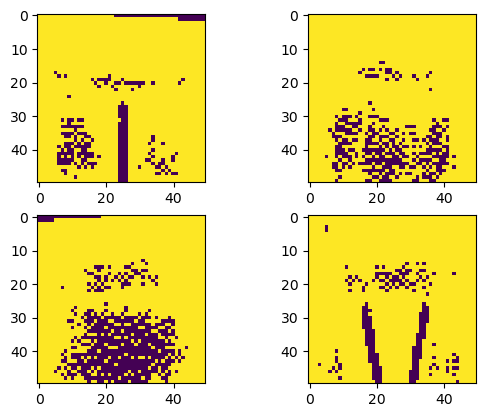

In [13]:
plot_grids(upper, row=50, col=50)

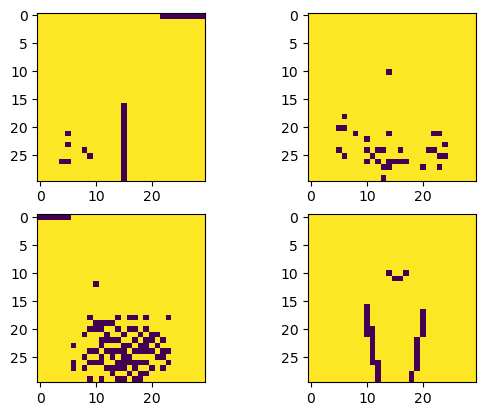

In [14]:
plot_grids(upper, row=30, col=30)

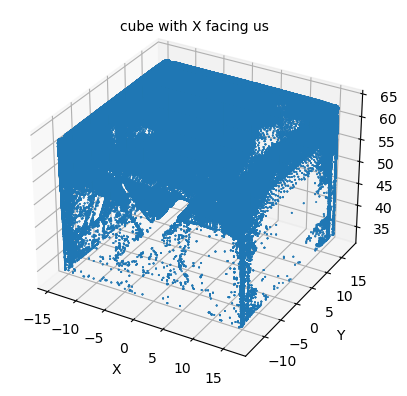

In [15]:
final_cube = rotate_z(aligned_cube, degrees_to_face_y(upper) - 90)

plot_3d(final_cube, s=0.1, title='cube with X facing us')

In [16]:
target_surface = rotate_x(sample_target_surface(final_cube), 90)

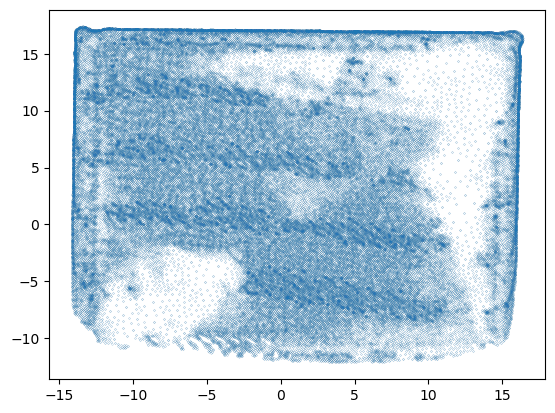

In [17]:
target_surface_2d = target_surface[:, [X, Z]]
plt.scatter(target_surface_2d[:, 0], target_surface_2d[:, 1], s=0.001)